# CNN for Image Classification

In this lab, you are given a dataset containing 6,000 pictures of cats and dogs (3,000 cats, 3,000 dogs) and asked to train a classifier built upon Convolutional Neural Networks (ConvNets) to classify images as "dogs" or "cats".

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import keras
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


### Exercise 1 
Split the dataset by selecting 4,800 pictures for training, 600 for validation, and 600 for testing.

In [2]:
img_width = 50
img_height = 50
num_classes = 2
DATA_DIR = './data/'
image_filenames = [DATA_DIR+i for i in os.listdir(DATA_DIR)] # use this for full dataset

# Split the data in three sets, 80% for training, 10% for validation and 10% for testing
# make sure that the image filenames have a fixed order before shuffling
# Add your code here

# have a fixed order before shuffling
np.random.seed(12345)
np.random.shuffle(image_filenames)

X = []  # array of resized images from given dir
Y = []  # label of image (dog-0 / cat-1)
for image in image_filenames:
    # read and resize the image
    X.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC)) 
    if 'dog' in image:
        Y.append(0)
    elif 'cat' in image:
        Y.append(1)

# split the data in three sets, 80% for training, 10% for validation and 10% for testing
X = np.array(X)
Y = np.array(Y)
split_1 = int(0.8 * len(X))
split_2 = int(0.9 * len(X))
X_train, Y_train = X[:split_1], Y[:split_1]
X_val, Y_val = X[split_1:split_2], Y[split_1:split_2]
X_test, Y_test = X[split_2:], Y[split_2:]

### Exercise 2
Train a Convolutional Neural Network (ConvNet) on the training set. The general structure of the ConvNet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers. A Conv2D layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. A MaxPooling2D layer is used to downscale input in both the vertical and horizontal dimensions.

In [3]:
# Add your code here
batch_size = 16

# model a convolutional neural network: a Conv2D layer and a MaxPooling2D layer
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width,img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # Flattening
model.add(Dense(64)) # Full connection
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))  # Sigmoid function at the end because we have just two classes

# compile the model
model.compile(loss='binary_crossentropy', # binary classification
              optimizer='rmsprop',
              metrics=['accuracy'])

# see the detail of our model
model.summary()

# augmentation configuration for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255, # scale the image between 0 and 1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# prepare generators for training and validation sets
train_generator = train_datagen.flow(X_train, Y_train, batch_size=16)
validation_generator = val_datagen.flow(X_val, Y_val, batch_size=16)

# training the model: train for 32 epochs with 300 steps per epoch
fit_model = model.fit_generator(
    train_generator, 
    steps_per_epoch=4800//batch_size,
    epochs=32,
    validation_data=validation_generator,
    validation_steps=600//batch_size
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1179712   
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
__________

#### Finding:
After a small epoch, accuracy on the training set is close to 83%, while on the validation set is close to 73%.

### Exercise 3

Output the training/validation loss and accuracy curves. Also print the classification results (e.g., classification accuracy, confusion matrix, precision-recall curves and/or ROC curves) on the test set.

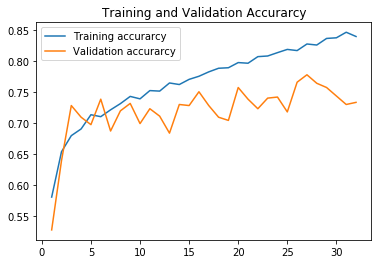

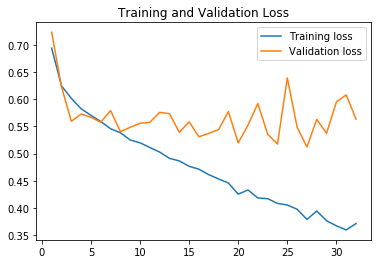


===================Model Accuracy==================
The accuracy of model is: 72.0%

===============Classification Report==============
              precision    recall  f1-score   support

           0       0.66      0.86      0.75       293
           1       0.81      0.59      0.68       307

   micro avg       0.72      0.72      0.72       600
   macro avg       0.74      0.72      0.72       600
weighted avg       0.74      0.72      0.72       600


=================Confusion Matrix================
[[252  41]
 [127 180]]


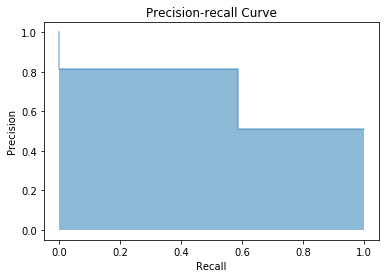

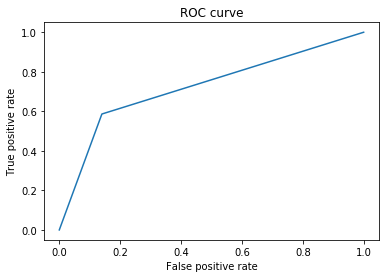

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, accuracy_score
from sklearn.utils.fixes import signature  # For plotting precision-recall curve
# Add your code here

# Plot loss and accuracy curves
# get the accuracy and loss form the history object
acc = fit_model.history['acc']
val_acc = fit_model.history['val_acc']
loss = fit_model.history['loss']
val_loss = fit_model.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation Accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predict the label of test set
# augmentation configuration: only rescaling for testing
test_datagen = ImageDataGenerator(rescale=1./255) 
# prepare generator and predict
test_generator = test_datagen.flow(X_test, batch_size=1,shuffle=False)
probabilities = model.predict_generator(test_generator, steps=600)
prediction_label = np.around(probabilities)

# Accuracy
print("\n===================Model Accuracy==================")
print("The accuracy of model is: {:.1%}".format(accuracy_score(Y_test,prediction_label)))

# Classification results
print("\n===============Classification Report==============")
print(classification_report(Y_test,prediction_label))

# Confusion matrix
print("\n=================Confusion Matrix================")
print(confusion_matrix(Y_test,prediction_label))

# Precision recall curve
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
precision, recall, thresholds = precision_recall_curve(Y_test,prediction_label,pos_label=1)
plt.step(recall,precision,where='post',alpha=0.5)
plt.fill_between(recall,precision,alpha=0.5, **step_kwargs)
plt.title('Precision-recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test,prediction_label,pos_label=1)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


#### Finding:
The accuracy of training and validation sets get higher and higer to around 83% and 73% respectively.  
The loss of training and validation sets get lower and lower to around 40% and 55% respectively.  
The accuracy of this model in testing set is around 72%.

### Exercise 4

Explore different network architectures (e.g., stacking 4 Conv2D+MaxPooling2D layers) and various ways in tuning the model parameters to see if you can improve the model performance on the validation set.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 128)         73856     
__________

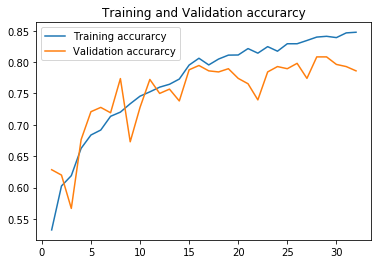

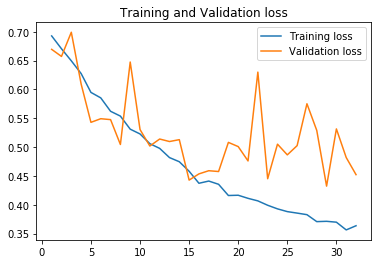

In [5]:
# Add your code here
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(img_width,img_height,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model.add(Dropout(0.5)) # add a dropout layer to overcome the problem of overfitting
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model2.summary()

fit_model2 = model2.fit_generator(
    train_generator, 
    steps_per_epoch=4800//batch_size,
    epochs=32,
    validation_data=validation_generator,
    validation_steps=600//batch_size
)

# plot accuracy and loss
acc = fit_model2.history['acc']
val_acc = fit_model2.history['val_acc']
loss = fit_model2.history['loss']
val_loss = fit_model2.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### Finding:
After repeating the Conv2D layer and MaxPooling2D layer four times, tuning the parameters of Conv2D layers and adding Dropout layer to prevent overfitting,
we can improve the model performance where accuracy of validationn set is around 80%, and accuracy of training set is around 85%.

### Exercise 5

Apply the trained model on the testing set and output the classification results.


===================Model Accuracy==================
The accuracy of model is: 81.2%

===============Classification Report==============
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       293
           1       0.82      0.81      0.82       307

   micro avg       0.81      0.81      0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600


=================Confusion Matrix================
[[238  55]
 [ 58 249]]

==============Precision-recall Curve=============


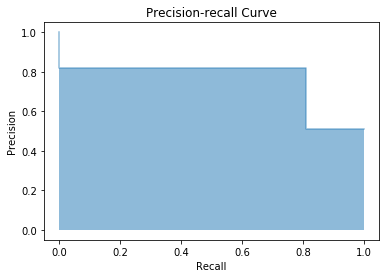


=====================ROC Curve====================


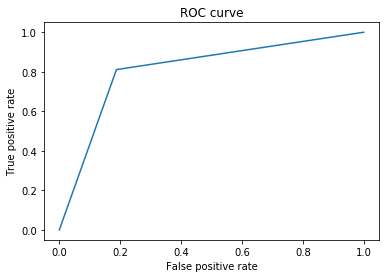

In [6]:
# Add your code here
test_datagen = ImageDataGenerator(rescale=1./255) 
test_generator = test_datagen.flow(X_test, batch_size=1,shuffle=False)
probabilities2 = model2.predict_generator(test_generator, steps=600)
prediction_label2 = np.around(probabilities2)

# Accuracy
print("\n===================Model Accuracy==================")
print("The accuracy of model is: {:.1%}".format(accuracy_score(Y_test,prediction_label2)))

# Classification results
print("\n===============Classification Report==============")
print(classification_report(Y_test,prediction_label2))

# Confusion matrix
print("\n=================Confusion Matrix================")
print(confusion_matrix(Y_test,prediction_label2))

# Precision recall curve
print("\n==============Precision-recall Curve=============")
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
precision, recall, thresholds = precision_recall_curve(Y_test,prediction_label2,pos_label=1)
plt.step(recall,precision,where='post',alpha=0.5)
plt.fill_between(recall,precision,alpha=0.5, **step_kwargs)
plt.title('Precision-recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve
print("\n=====================ROC Curve====================")
fpr, tpr, thresholds = roc_curve(Y_test,prediction_label2,pos_label=1)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


#### Finding:
The performance of model has been improved.  
The accuracy of testing set has been incresed to 81.2%.

### Exercise 6 

Plot the saliency map of original image to see which part is important for making classification decisions. You can refer to the following blog article on how to generate visualisation results of the filters in the ConvNets.
https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

#### Warning:
It will take pretty much time to run the code below.

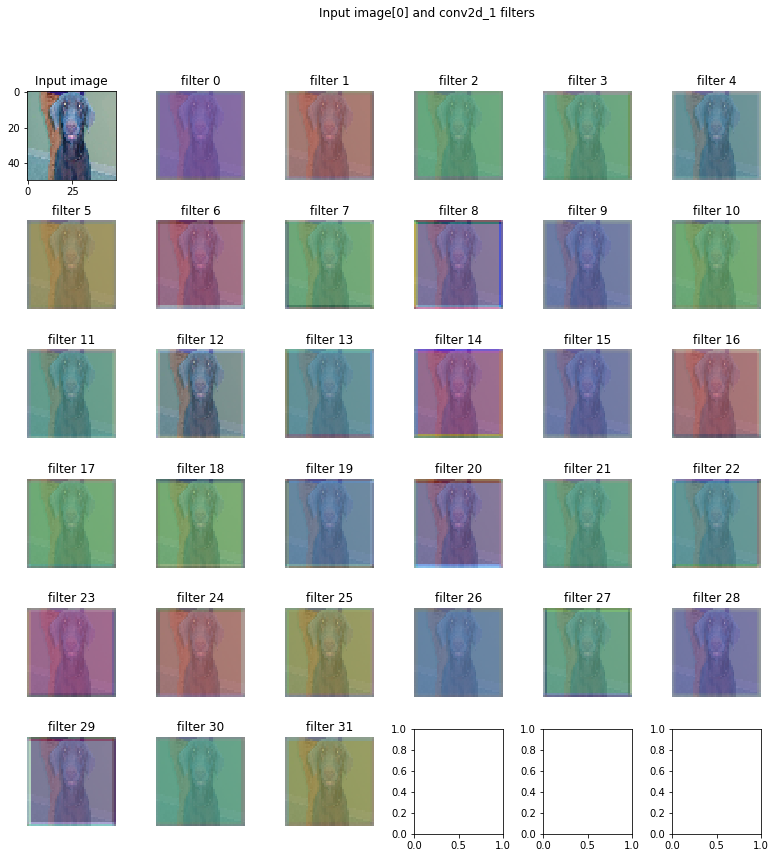

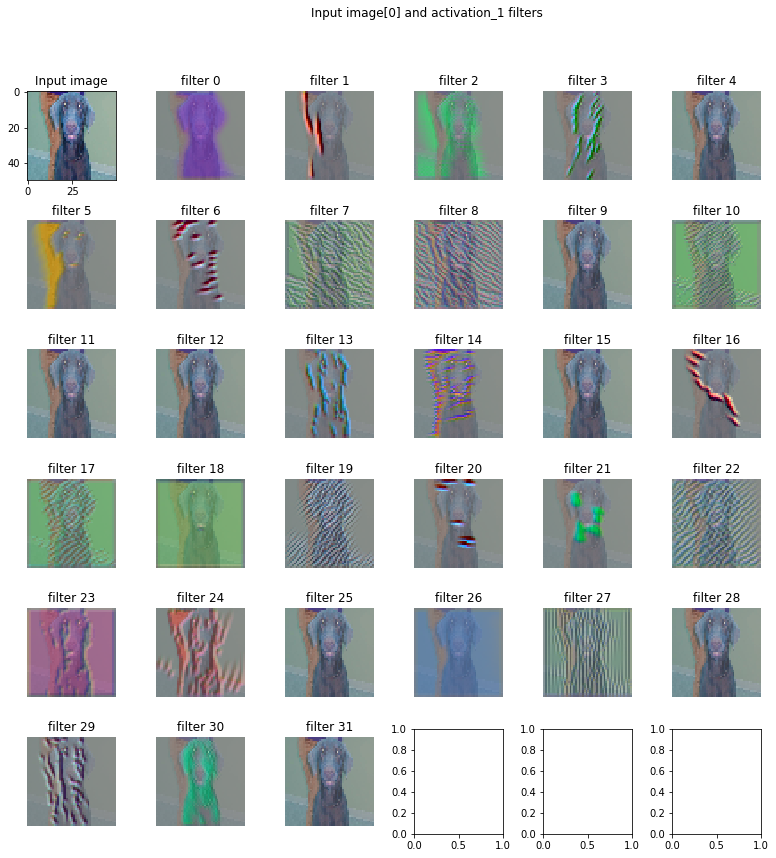

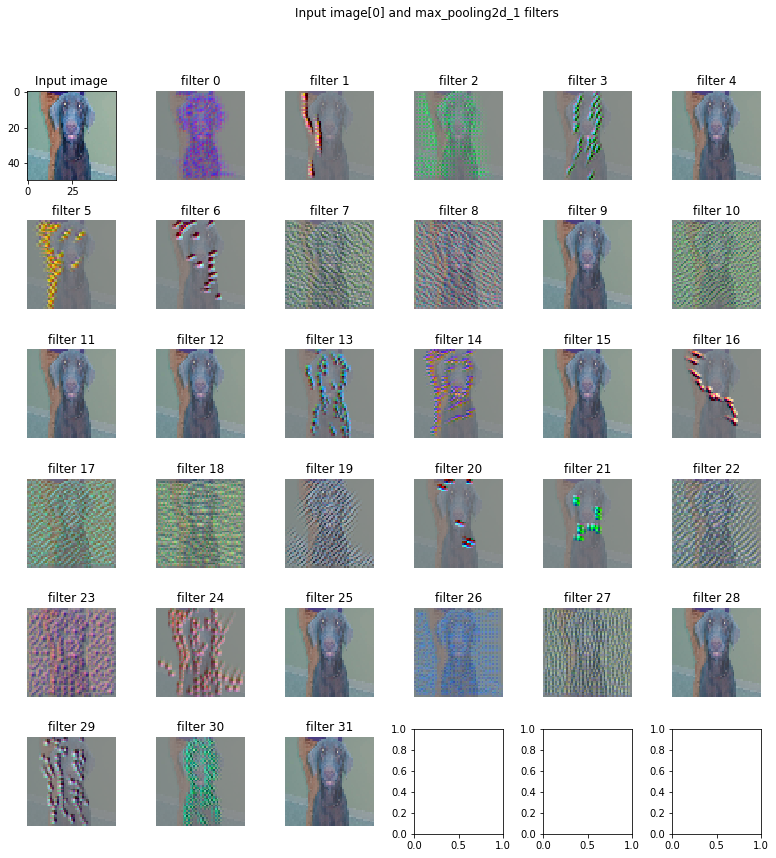

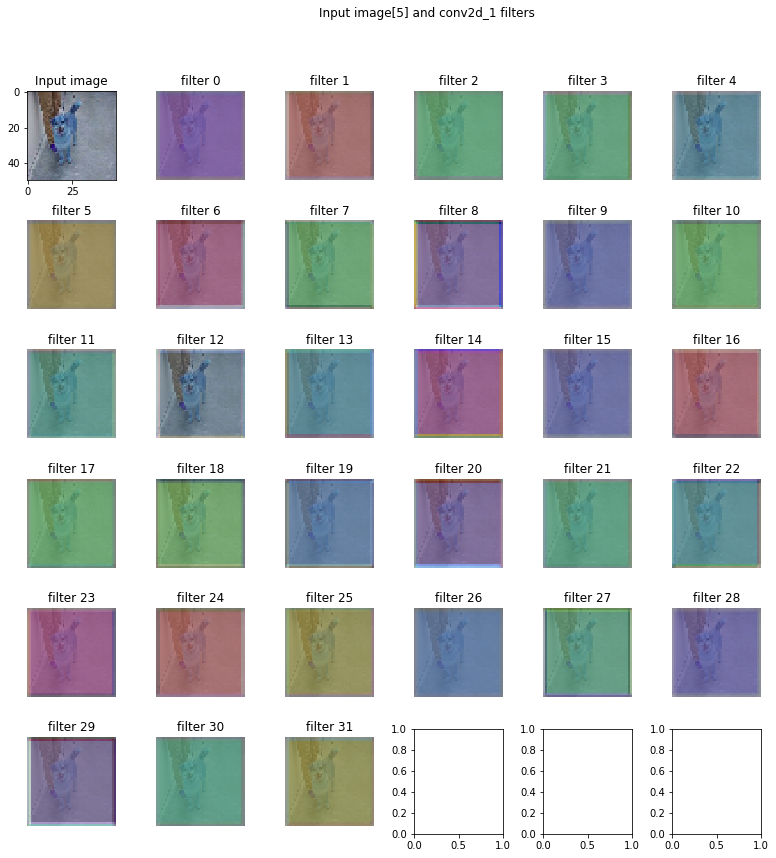

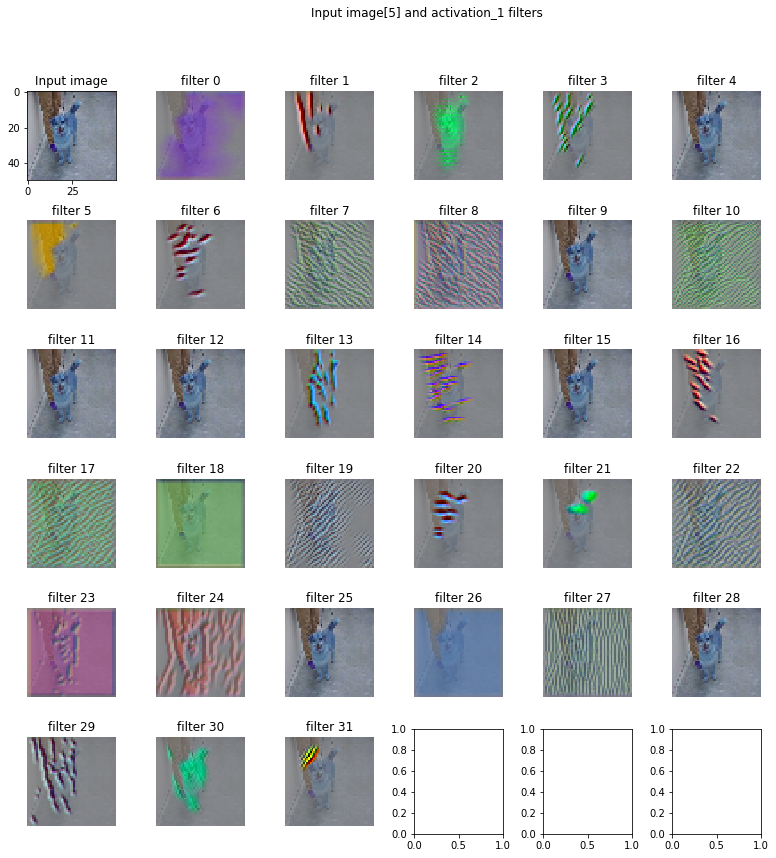

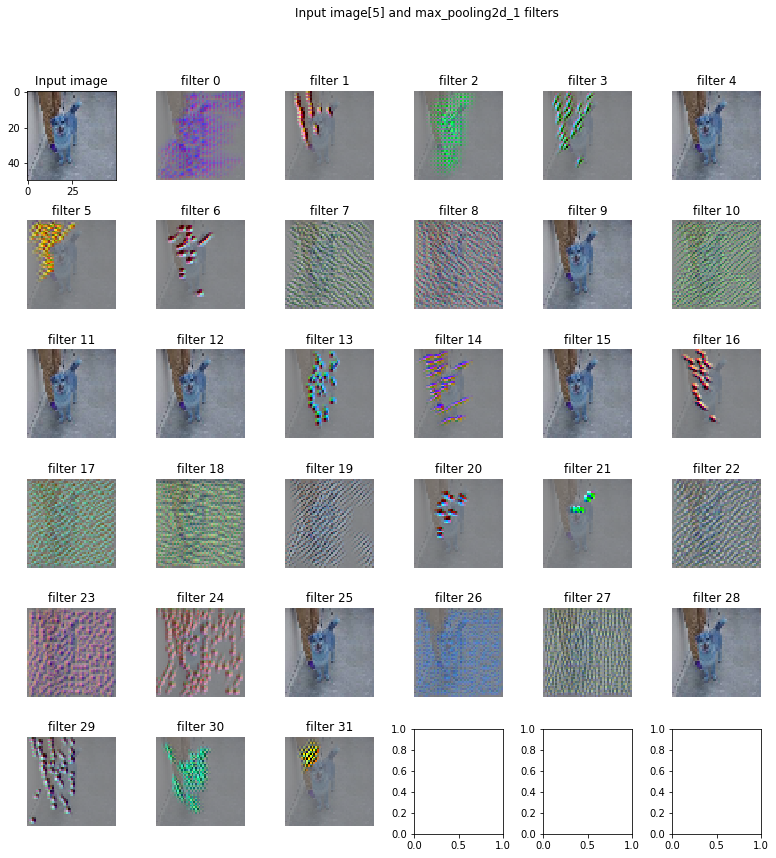

In [18]:
# Add your code here
from keras import backend as K

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0, ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x


def generate_map(img, model, layer_name):
    layer_output = layer_dict[layer_name].output
    img_ascs = []

    for filter_index in range(layer_output.shape[3]):
        # Build a loss function that maximizes the activation of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # Compute the gradient of the input picture with this loss
        grads = K.gradients(loss, model.input)[0]

        # Normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # This function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # Step size for gradient ascent
        step = 5.

        img = img.reshape((1, 50, 50, 3))
        img_asc = np.array(img).astype(np.float64)

        # Run gradient ascent for 20 steps
        for i in range(20):
            _, grads_val = iterate([img_asc])
            img_asc += grads_val * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((50, 50, 3)))
    
    return img_ascs


layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_list = ['conv2d_1', 'activation_1', 'max_pooling2d_1']
cat_dog = [0,5]
for img_index in cat_dog:
    img = X_train[img_index]
    for layer in layer_list:
        layer_name = layer
        img_ascs = generate_map(img, model, layer_name)

        plot_x, plot_y = 6, 6
        fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
        fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])

        ax[0, 0].imshow(img.reshape((50, 50, 3)))
        ax[0, 0].set_title('Input image')
        fig.suptitle("Input image["+ str(img_index) + "] and " + layer_name + " filters")

        for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
            if x == 0 and y == 0:
                continue

            if x * plot_y + y > 32:
                break
            ax[x, y].imshow(img_ascs[x * plot_y + y - 1])
            ax[x, y].set_title('filter {}'.format(x * plot_y + y - 1))
            ax[x, y].axis('off')


#### Finding:
After ploting the Conv2D, Activation and MaxPooling layer of cat and dog, we can find that the ear of cat/dog is the most important fearture for making classification decision.